In [ ]:
from numpy.random import randint
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras.datasets.mnist import load_data
#from keras.datasets.cifar10 import load_data
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
# Get images ready by loading and preprocessing.
def get_images_ready(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X/255.  # scale from [0,255] to [0,1]
    print(X.shape, trainy.shape)
    return [X, trainy]


In [ ]:
#Pick a subset of images.
num_images = 120
def select_subset_images(dataset, n_samples=num_images, n_classes=10):
 	X, y = dataset
 	X_list, y_list = list(), list()
 	n_per_class = int(n_samples / n_classes) #Number of samples per class.
 	for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
 	return np.asarray(X_list), np.asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y


In [ ]:
#Define the dataset.
dataset = get_images_ready()
#Get subset images and corresponding labels
X, Y = select_subset_images(dataset)


11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


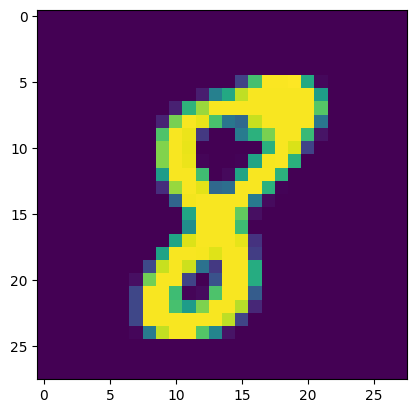

In [ ]:
#View some random images
i = randint(0, X.shape[0])
plt.imshow(X[i])


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#### NOTE: We will be using sparse_categorical_crossentropy loss so we will not convert Y to categorical ####


In [ ]:
#Define Model with BatchNormalization and Dropout
# define cnn model

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
	# compile model
#opt = SGD(lr=0.01, momentum=0.9)
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define model
print(model.summary())

history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)

model.save('cnn_model_for_mnist_100epochs.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 113162 (442.04 KB)
Trainable params: 11316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


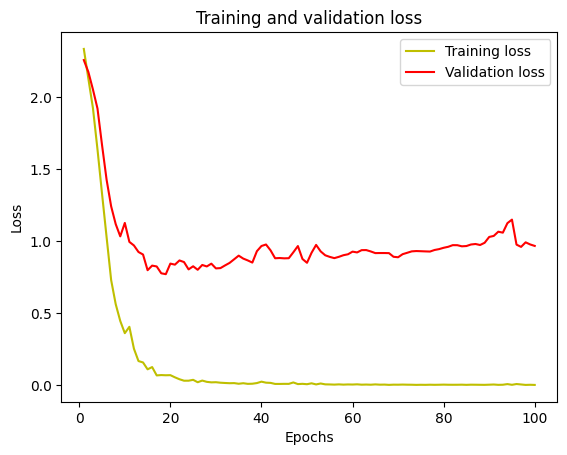

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


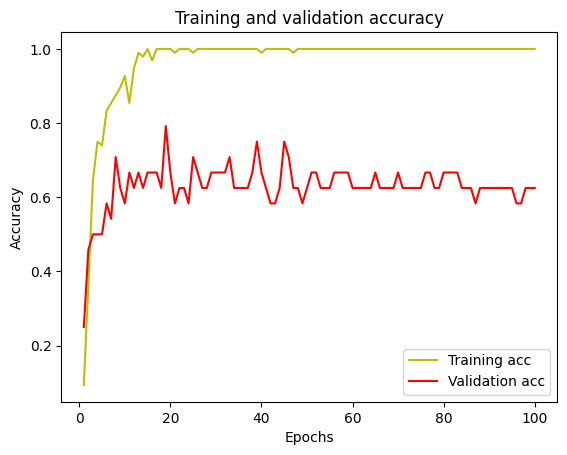

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#Test the model on all test data - 10,000 images

from keras.models import load_model
# load the model
my_model = load_model('cnn_model_for_mnist_100epochs.h5')

# load the dataset
(_, _), (test_X, test_y) = load_data()

# expand to 3d, e.g. add channels
test_X = np.expand_dims(test_X, axis=-1)

# convert from ints to floats
test_X = test_X.astype('float32')

# scale from [0,255] to [-1,1]
test_X = test_X /255.

# evaluate the model
_, test_acc = my_model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))


Test Accuracy: 78.860%


313/313 [==============================] - 3s 10ms/step


<Axes: >

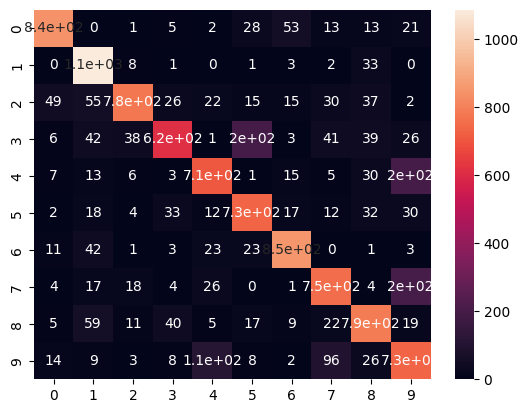

In [ ]:
# Predicting the Test set results
y_pred_test = model.predict(test_X)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_y, prediction_test)
sns.heatmap(cm, annot=True)